<b><font color='darkred'>
Verwenden statistischer Größen der Zeitreihen als Features<br><br>
MLP - Multi-Layer Perceptron  
-----------------
- Power[W] &nbsp;&emsp;&emsp; ➔  Generatorleistung, Energie &emsp;➔ p
- Force[N] &emsp;&emsp;&emsp;➔  Pressenkraft &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;➔ f
- Distance[mm] &nbsp;➔  Sonotrodenvorschub &emsp;&emsp;&emsp;&emsp;➔ d



In [39]:
from scipy.stats import uniform, randint
from sklearn import preprocessing, model_selection
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
import xgboost as xgb
import helper

In [40]:
pca = False           # PCA Anwendung ja oder nein?
n_components = 0.98

SCALE = 2000    # Skalierung für Zielvariable Zugfestigkeit


STATS = [
    # Power (p_*)
    "p_mean", "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_iqr", "p_f_ratio", "p_d_ratio", "p_t_ratio",
    
    # Force (f_*)
    #"f_mean", "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_iqr", "f_d_ratio", "f_t_ratio",
    
    # Distance (d_*)
    "d_mean", "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_iqr", "d_t_ratio", "d_b75",
    
    # Zeitmerkmale
    "t_max",
]

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [41]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [42]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [43]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [44]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalieren Trainings- und Testdaten mit PCA

In [45]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

In [46]:
if pca == True:
    pca_scaler = PCA(n_components=n_components)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

<b><font color='lightgreen'> Kontrollanzeige t-SNE

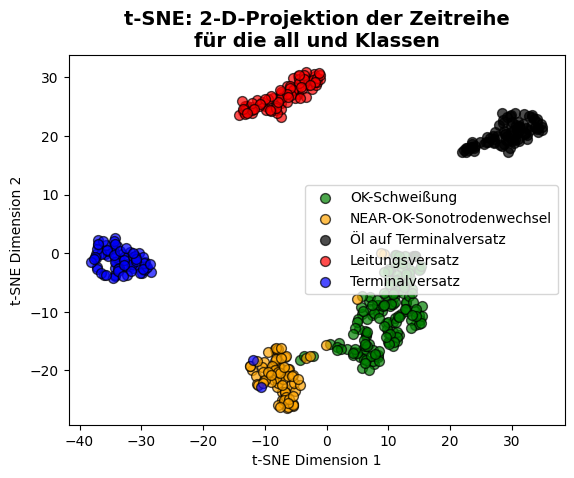

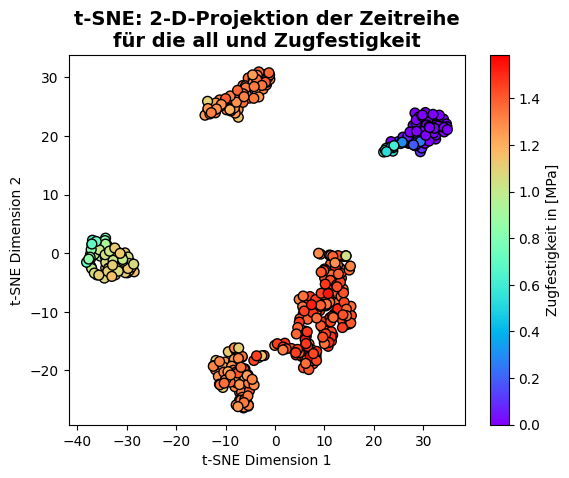

In [47]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> MLP für Klassifikation (Hyperparametersuche - Random Search)

In [48]:
# Hyperparameter-Suchraum definieren
param_dist_class = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # Netzarchitektur
    'activation': ['relu', 'tanh'],              # Aktivierungsfunktion
    'solver': ['adam', 'lbfgs'],                 # Optimierungsalgorithmus
    'alpha': uniform(0.0001, 0.01),              # L2-Regularisierung
    'learning_rate_init': uniform(0.001, 0.1),   # Lernrate
    'max_iter': randint(200, 1500)               # Iterationen
}
# RandomizedSearchCV erstellen
mlp_clf = MLPClassifier(random_state=42)

random_search_class = model_selection.RandomizedSearchCV(
    mlp_clf, 
    param_distributions=param_dist_class, 
    n_iter=20, 
    cv=3, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Modell trainieren
random_search_class.fit(X_train_scaled, label_train)

# Bestes Modell auswählen
best_mlp_clf = random_search_class.best_estimator_
best_params = {k: round(float(v), 4) if isinstance(v, float) else v for k, v in random_search_class.best_params_.items()}

print("\n Beste Hyperparameter:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Vorhersagen
pred_train = best_mlp_clf.predict(X_train_scaled)
pred_test  = best_mlp_clf.predict(X_test_scaled)

# Modellbewertung
helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Beste Hyperparameter:
activation: relu
alpha: 0.0048
hidden_layer_sizes: (100, 100)
learning_rate_init: 0.0982
max_iter: 842
solver: adam
                        precision    recall  f1-score   support

                    ok      1.000     1.000     1.000        43
   near_ok_sonowechsel      0.760     1.000     0.864        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.750     0.857        24

              accuracy                          0.950       120
             macro avg      0.952     0.950     0.944       120
          weighted avg      0.962     0.950     0.950       120



,Train,Test
Metric,,
Accuracy,0.969,0.950
Precision,0.972,0.962
Recall,0.969,0.950
F1-score,0.969,0.950


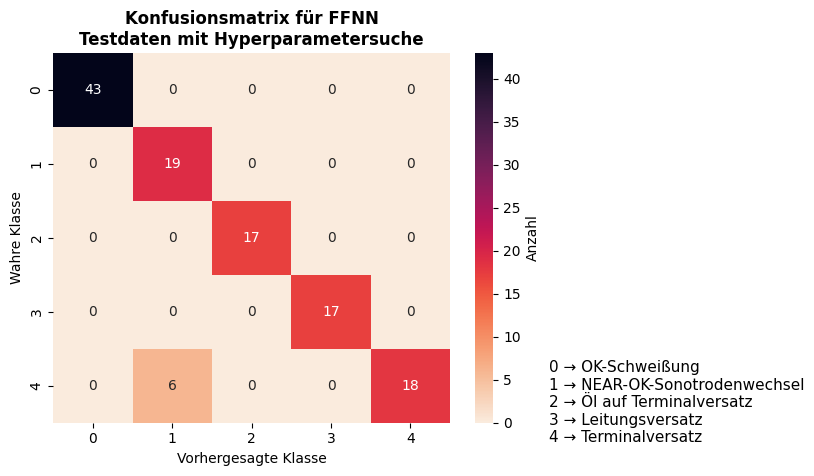

In [25]:
helper.plot_confusion(label_test, pred_test, 'FFNN\nTestdaten mit Hyperparametersuche')

<b><font color='lightgreen'><h3> MLP für Regression (Hyperparametersuche - Random Search)

param_dist_regr = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # Verschiedene Architekturen
    'activation': ['relu', 'tanh'],             # Aktivierungsfunktion
    'solver': ['adam', 'lbfgs'],                         # Optimierer # 
    'alpha': uniform(0.0001, 0.01),             # L2-Regularisierung
    'learning_rate_init': uniform(0.001, 0.1),  # Lernrate
    'max_iter': [2000, 5000, 10000], # randint(100, 4000),              # Iterationen
    "tol": [1e-3],  # Konvergenztoleranz
}

In [26]:
# Hyperparameter-Suchraum definieren
param_dist_regr = {
    "hidden_layer_sizes": [
        (32,),
        (64,),
    ],
    "activation": ["relu", "tanh"],
    "solver": ["lbfgs"],
    "alpha": [0.001, 0.01, 0.1],
    "max_iter": [2000, 5000, 10000],
    "tol": [1e-3],  # Konvergenztoleranz
}

# RandomizedSearchCV erstellen
mlp_reg = MLPRegressor(random_state=42)

random_search_regr = model_selection.RandomizedSearchCV(
    mlp_reg, 
    param_distributions=param_dist_regr, 
    n_iter=20, 
    cv=5, 
    scoring="neg_mean_squared_error", # scoring='r2', # estimator score = Standard
    verbose=0, 
    n_jobs=-1, 
    random_state=42
)

# Modell trainieren
random_search_regr.fit(X_train_scaled, festigkeit_train)

# Bestes Modell auswählen
best_mlp_reg = random_search_regr.best_estimator_
best_params = {k: round(float(v), 4) if isinstance(v, float) else v for k, v in random_search_class.best_params_.items()}

print("\n Beste Hyperparameter:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Vorhersagen
pred_train = best_mlp_reg.predict(X_train_scaled)
pred_test  = best_mlp_reg.predict(X_test_scaled)

# Umskalieren
print(pred_train.shape, pred_test.shape)  
# Zurückskalieren mit StandardScaler
#pred_train = std_scaler.inverse_transform(pred_train.reshape(1, -1)).flatten()
#pred_test  = std_scaler.inverse_transform(pred_test.reshape(1, -1)).flatten()

# Modellbewertung
helper.get_metric_table_regr(festigkeit_train, pred_train, festigkeit_test, pred_test, SCALE)


 Beste Hyperparameter:
activation: relu
alpha: 0.0048
hidden_layer_sizes: (100, 100)
learning_rate_init: 0.0982
max_iter: 842
solver: adam
(480,) (120,)


,Train,Test
Metric,,
MSE,13776.07,13236.77
RMSE,117.37,115.05
MAE,89.13,82.49
R²,0.98,0.98


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

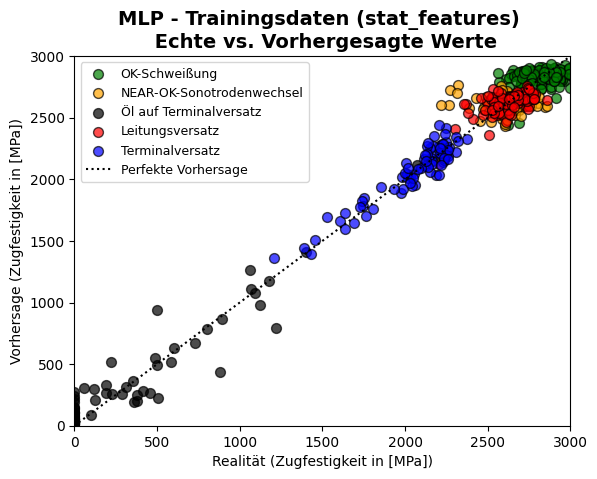

In [27]:
if pca == True:
    helper.plot_pred(pred_train, festigkeit_train, label_train, 'MLP mit PCA - Trainingsdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)
else:
    helper.plot_pred(pred_train, festigkeit_train, label_train, 'MLP - Trainingsdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)

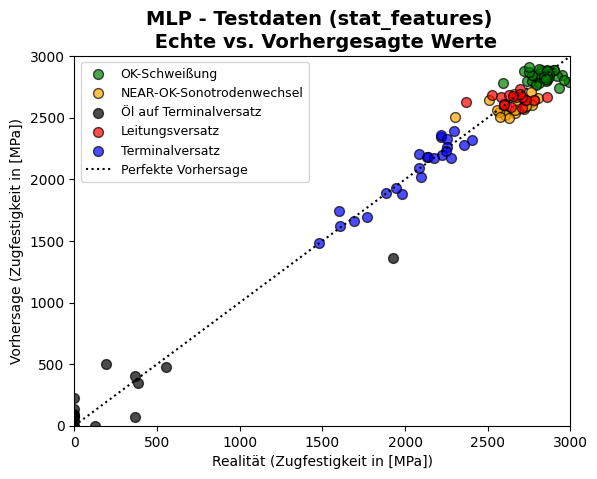

In [28]:
if pca == True:
    helper.plot_pred(pred_test, festigkeit_test, label_test, 'MLP mit PCA - Testdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)
else:
    helper.plot_pred(pred_test, festigkeit_test, label_test, 'MLP - Testdaten (stat_features) \n Echte vs. Vorhergesagte Werte', 'mit Linie', SCALE)